<a href="https://colab.research.google.com/github/Mihawk1891/PixelPatrol/blob/main/PixelPatrol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test) = load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,LeakyReLU,Dropout
from keras.optimizers import Adam
import numpy as np
from keras.utils import plot_model

In [34]:

def descriminator(in_shape = (32,32,3)):

  model = Sequential()

  model.add(Conv2D(64,(3,3),padding= "same" , input_shape = in_shape))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,(3,3),padding= "same" , strides=(2,2)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,(3,3),padding= "same" , strides=(2,2)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256,(3,3),padding= "same" , strides=(2,2)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  opt = Adam(learning_rate=0.0002,beta_1=0.5)

  model.compile(optimizer = opt, loss = 'binary_crossentropy',metrics = ['accuracy'])

  return model

In [35]:
model = descriminator()

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 522,497 (1.99 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def load_real_sample():

  (x_train,_),(_,_) = load_data()

  x = x_train.astype('float32')

  x = (x-127.5)/127.5

  return x

In [37]:
x = load_real_sample()
x.shape

(50000, 32, 32, 3)

In [38]:
def generate_real_sample(dataset,n_sample):

  ix = np.random.randint(0,dataset.shape[0],n_sample)

  x = dataset[ix]
  y = np.ones((n_sample,1))

  return x,y

In [39]:
def generate_fake_sample(n_sample):

  x = np.random.rand(32 * 32 * 3 * n_sample)
  x = -1 + x * 2
  x = x.reshape((n_sample,32,32,3))

  y = np.zeros((n_sample,1))

  return x,y

In [40]:
x,y = generate_fake_sample(64)

In [41]:
def train_descriminator(model,dataset,n_iter=20,n_batch=128):

  half_batch = n_batch//2

  for i in range(n_iter):

    x_real,y_real = generate_real_sample(dataset,half_batch)

    _,real_acc = model.train_on_batch(x_real,y_real)

    x_fake,y_fake = generate_fake_sample(half_batch)

    _,fake_acc = model.train_on_batch(x_fake,y_fake)

    print(f'{i+1} . real = {real_acc * 100}% , fake = {fake_acc * 100}% ')

In [42]:
model = descriminator()

dataset = load_real_sample()

train_descriminator(model,dataset)

1 . real = 53.125% , fake = 26.5625% 
2 . real = 50.52083134651184% , fake = 38.671875% 


3 . real = 50.93749761581421% , fake = 43.48958432674408% 
4 . real = 51.5625% , fake = 47.4609375% 
5 . real = 52.95138955116272% , fake = 52.656251192092896% 
6 . real = 56.39204382896423% , fake = 58.72395634651184% 
7 . real = 61.77884340286255% , fake = 64.39732313156128% 
8 . real = 66.56249761581421% , fake = 68.65234375% 
9 . real = 70.40441036224365% , fake = 72.04861044883728% 
10 . real = 73.4375% , fake = 74.76562261581421% 
11 . real = 75.66964030265808% , fake = 76.77556872367859% 
12 . real = 77.6494562625885% , fake = 78.58073115348816% 
13 . real = 79.43750023841858% , fake = 80.22836446762085% 
14 . real = 80.90277910232544% , fake = 81.58482313156128% 
15 . real = 82.1659505367279% , fake = 82.76041746139526% 
16 . real = 83.31653475761414% , fake = 83.837890625% 
17 . real = 84.32765007019043% , fake = 84.78860259056091% 
18 . real = 85.22321581840515% , fake = 85.63368320465088% 
19 . real = 86.02195978164673% , fake = 86.38980388641357% 
20 . real = 86.73878312110

In [43]:
from keras.models import Sequential
from keras.layers import Dense,Reshape,Conv2D,Conv2DTranspose,LeakyReLU

In [44]:
def Model_a(latent_dim): #Model_a is the generator

  model = Sequential()

  n_nodes = 256 * 4 * 4

  model.add(Dense(n_nodes,input_dim = latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((4,4,256)))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))

  return model

In [53]:
model1 = Model_a(50)

model1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 4096)                │         208,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 8, 8, 128)           │         524,416 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_33 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 16, 16, 128)         │         262,272 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_34 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 32, 32, 128)         │         262,272 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_35 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,261,315 (4.81 MB)

 Trainable params: 1,261,315 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
def generate_latent_points(latent_dim,n_sample):

  x_input = np.random.randn(latent_dim * n_sample)
  x_input = x_input.reshape(n_sample,latent_dim)

  return x_input

In [55]:
def generate_fake_sample_by_generator(g_model,latent_dim,n_sample):

  x_input = generate_latent_points(latent_dim,n_sample)

  x = g_model.predict(x_input)

  y = np.zeros((n_sample,1))

  return x,y

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


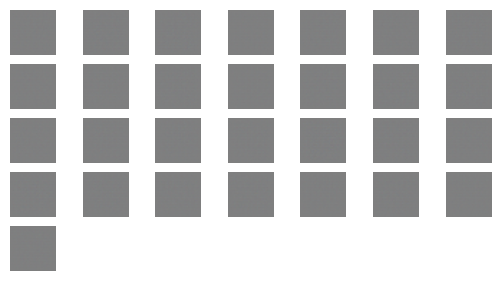

In [59]:
model = Model_a(50)

x,y = generate_fake_sample_by_generator(model,50,29)

x = (x+1)/2.0

for i in range(29):

  plt.subplot(7,7,1+i)

  plt.axis('off')

  plt.imshow(x[i])

plt.show()

In [64]:
def gan(g_model,d_model):

  d_model.trainable = False

  model = Sequential()

  model.add(g_model)

  model.add(d_model)

  opt = Adam(learning_rate= 0.0002,beta_1 = 0.5)

  model.compile(optimizer = opt,loss = 'binary_crossentropy')

  return model

In [65]:
d_model = descriminator()

g_model = Model_a(50)

model = gan(g_model,d_model)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_20 (Sequential)           │ (None, 32, 32, 3)           │       1,261,315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ (None, 1)                   │         522,497 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,783,812 (6.80 MB)

 Trainable params: 1,261,315 (4.81 MB)

 Non-trainable params: 522,497 (1.99 MB)

In [66]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=20,n_batch=128):

  batch_per_epoch = dataset.shape[0]//n_batch
  half_batch = n_batch//2

  for i in range(n_epochs):
    for j in range(batch_per_epoch):

      x_real,y_real = generate_real_sample(dataset,half_batch)

      d_loss1,_ = d_model.train_on_batch(x_real,y_real)

      x_fake,y_fake = generate_fake_sample_by_generator(g_model,latent_dim,half_batch)

      d_loss2,_ = d_model.train_on_batch(x_fake,y_fake)

      x_gan = generate_latent_points(latent_dim,n_batch)

      y_gan = np.ones((n_batch,1))

      g_loss = gan_model.train_on_batch(x_gan,y_gan)

      print(f'{i+1}. {j+1}/{batch_per_epoch} : d1 = {d_loss1} , d2 = {d_loss2} , g = {g_loss}')

    if (i+1)%10 == 0:
      summerize_function(i,g_model,d_model,dataset,latent_dim)


In [67]:
def summerize_function(i,g_model,d_model,dataset,latent_dim,n_samples = 150):

  x_real,y_real = generate_real_sample(dataset,n_samples)

  _,acc_real = d_model.evaluate(x_real,y_real)

  x_fake,y_fake = generate_fake_sample_by_generator(g_model,latent_dim,n_samples)

  _,acc_fake = d_model.evaluate(x_fake,y_fake)

  print(f'Descriminator Accuracy: Real = {acc_real} , Fake = {acc_fake}')

  save_plot(x_fake,i)

  filename = 'generator_model_%03d.h5' % (i+1)
  g_model.save(filename)

In [69]:
def save_plot(example,epoch,n=7):

  example = (example + 1)/2.0

  for i in range(n * n):
    plt.subplot(n,n,i+1)

    plt.axis('off')

    plt.imshow(example[i])

  filename = 'Plot_generated.png' % (epoch+1)

  plt.savefig(filename)
  plt.close()

In [70]:
d_model = descriminator()

g_model = Model_a(50)

gan_model = gan(g_model,d_model)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
train(g_model,d_model,gan_model,dataset,latent_dim=50,n_epochs=100,n_batch=64)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1. 1/781 : d1 = 0.6756466031074524 , d2 = 0.6844321489334106 , g = [array(0.68443215, dtype=float32), array(0.68443215, dtype=float32), array(0.546875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1. 2/781 : d1 = 0.6841793060302734 , d2 = 0.686616837978363 , g = [array(0.68661684, dtype=float32), array(0.68661684, dtype=float32), array(0.4296875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1. 3/781 : d1 = 0.6867830157279968 , d2 = 0.6881017684936523 , g = [array(0.68810177, dtype=float32), array(0.68810177, dtype=float32), array(0.40625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1. 4/781 : d1 = 0.6876978874206543 , d2 = 0.688765287399292 , g = [array(0.6887653, dtype=float32), array(0.6887653, dtype=float32), array(0.38671875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1. 5/781 : d1 = 0.6883137226104736 , d2 = 0.6892338991165161 , g = [array(0.6892339, dtype=float32), array(0.6892339, dtype=float32), a